## Gear Shift decision maker based on Fuzzy logic algorithm

---

#### Inputs:
- Velocity (km/h)
- RPM (engine revolutions per minute)
- Throttle Level (car's accelerator pedal)

#### Output:
- Gear

---

#### Key concept making fuzzy rules:
1. When the car is driven as in normal/base mode by driver - it means lack of strong pressure on the accelerator pedal -> the car should stay on its current gear, unless:
    - RPM is high -> then gear should be shifted up to "sailing mode" on higher gear with less RPM
    - RPM is low ->  then car should also stay on the current gear to "sail"
2. When Throttle level is high it means, the driver wants to dynamicly accelerate, so the gear box should be shifted down, to put the engine into higher RPM, which means more power for the driver.

---

#### Linguistic variables:
- Velocity: very low, low, medium, high, (very high - current not implemented - useful when concerning higher velocity values > 140 km/h)
- RPM:      low, medium, high
- Throttle: low, medium, high

---

#### Defuzzyfication method: **defuzzifyWeightedAverage**
This function implements a **defuzzification** technique known as the **Weighted Average (or Center of Peaks)** method. It takes:

- `memberships`: a map of **fuzzy output labels (gear levels)** to their **membership values** (how strongly each gear is activated).
- `ranges`: a map from each label to a **triangular range** (`[start, peak, end]`), using the **peak** as a crisp representative value.

It computes the **weighted average** of the peaks of all output fuzzy sets, using the membership values as weights.

Pros:
- **Simple and Fast**: Easy to implement and computationally efficient.

Cons:
- **Ignores Shape of Membership Functions**: Only the peak values are used—this discards useful information about the full distribution.

---

#### Short introduction:
Current implementation is partially lack of precision espesially in low values of velocity. In the future should be consider to implement the idling gear, which should also appear when the car's velocity is 0, despite of whatever RPM and throttle level value is, because car is in idle mode (parking mode).
Moreover, the transitions from one to another gear should be smoother. This problem may occure due to defuzzyfication method which is currently used.

---

#### Summary
Summing up, the general trend and rules about shifting gears are clearly visible, but the future works should be focused on:
- Change ranges of linguistic varaibles to be more accurate to reality
- Implement more precise method of defuzzyfication


In [20]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as anim
from matplotlib.patches import Patch

#### C++ gear shift porogram mapped to python funciton

Functions Outputs:
- first value  : exact value for gear                        : float
- second value : approximate value to neasrest integer value : integer

In [2]:
def GearShift(velocity: int, rpm: int, throttleLevel: int):
    import subprocess

    result = subprocess.run([
        "../GearShift-Fuzzy.exe",
        "-v", str(velocity),
        "-r", str(rpm),
        "-t", str(throttleLevel)
    ], capture_output=True, text=True)

    output_parts = result.stdout.strip().split()

    if len(output_parts) >= 2:
        first_value = output_parts[0]
        second_value = output_parts[1]
        return float(first_value), int(second_value)
    else:
        print("Unexpected output:", result.stdout)
        return None, None


#### Minor tests

In [3]:
# test
# normal mode
assert GearShift(20, 1000, 10)[1] == 2

# strong acceleration -> gear should be shifted down
assert GearShift(20, 1000, 90)[1] == 1

# Idle or very slow movement, low throttle – expect low gear
assert GearShift(5, 900, 10)[1] == 1

# Cruising speed, moderate throttle – mid gear
assert GearShift(50, 2500, 40)[1] == 4

# Highway speed, low throttle – high gear
assert GearShift(90, 2000, 20)[1] == 5

# High RPM, low speed, high throttle – accelerating hard, downshift expected, but high RPM take precedence, so shift up
assert GearShift(30, 5000, 95)[1] == 3

# Medium speed, high RPM, low throttle – likely to upshift
assert GearShift(60, 4500, 10)[1] in [5, 6]

# Very high RPM and high speed with moderate throttle – likely to stay in high gear
assert GearShift(100, 6000, 50)[1] == 6

# Near gear threshold – check if fuzzy logic handles softly
assert GearShift(40, 2200, 60)[1] in [2, 3]  # borderline case

# normally 5-th gear, but strong acceleration - reduction to lower gear
assert GearShift(70, 1000, 90)[1] == 4


#### Visualization tests

As we can see below the key concepts which are:
- shifting down gear when rpm low and throttle level high
- shifting up gear when rpm high

are generally met.

- At high velocity and low RPM, the system tends to maintain or downshift to lower gears depending on throttle input.
- At low velocity and high RPM, the system chooses higher gears.

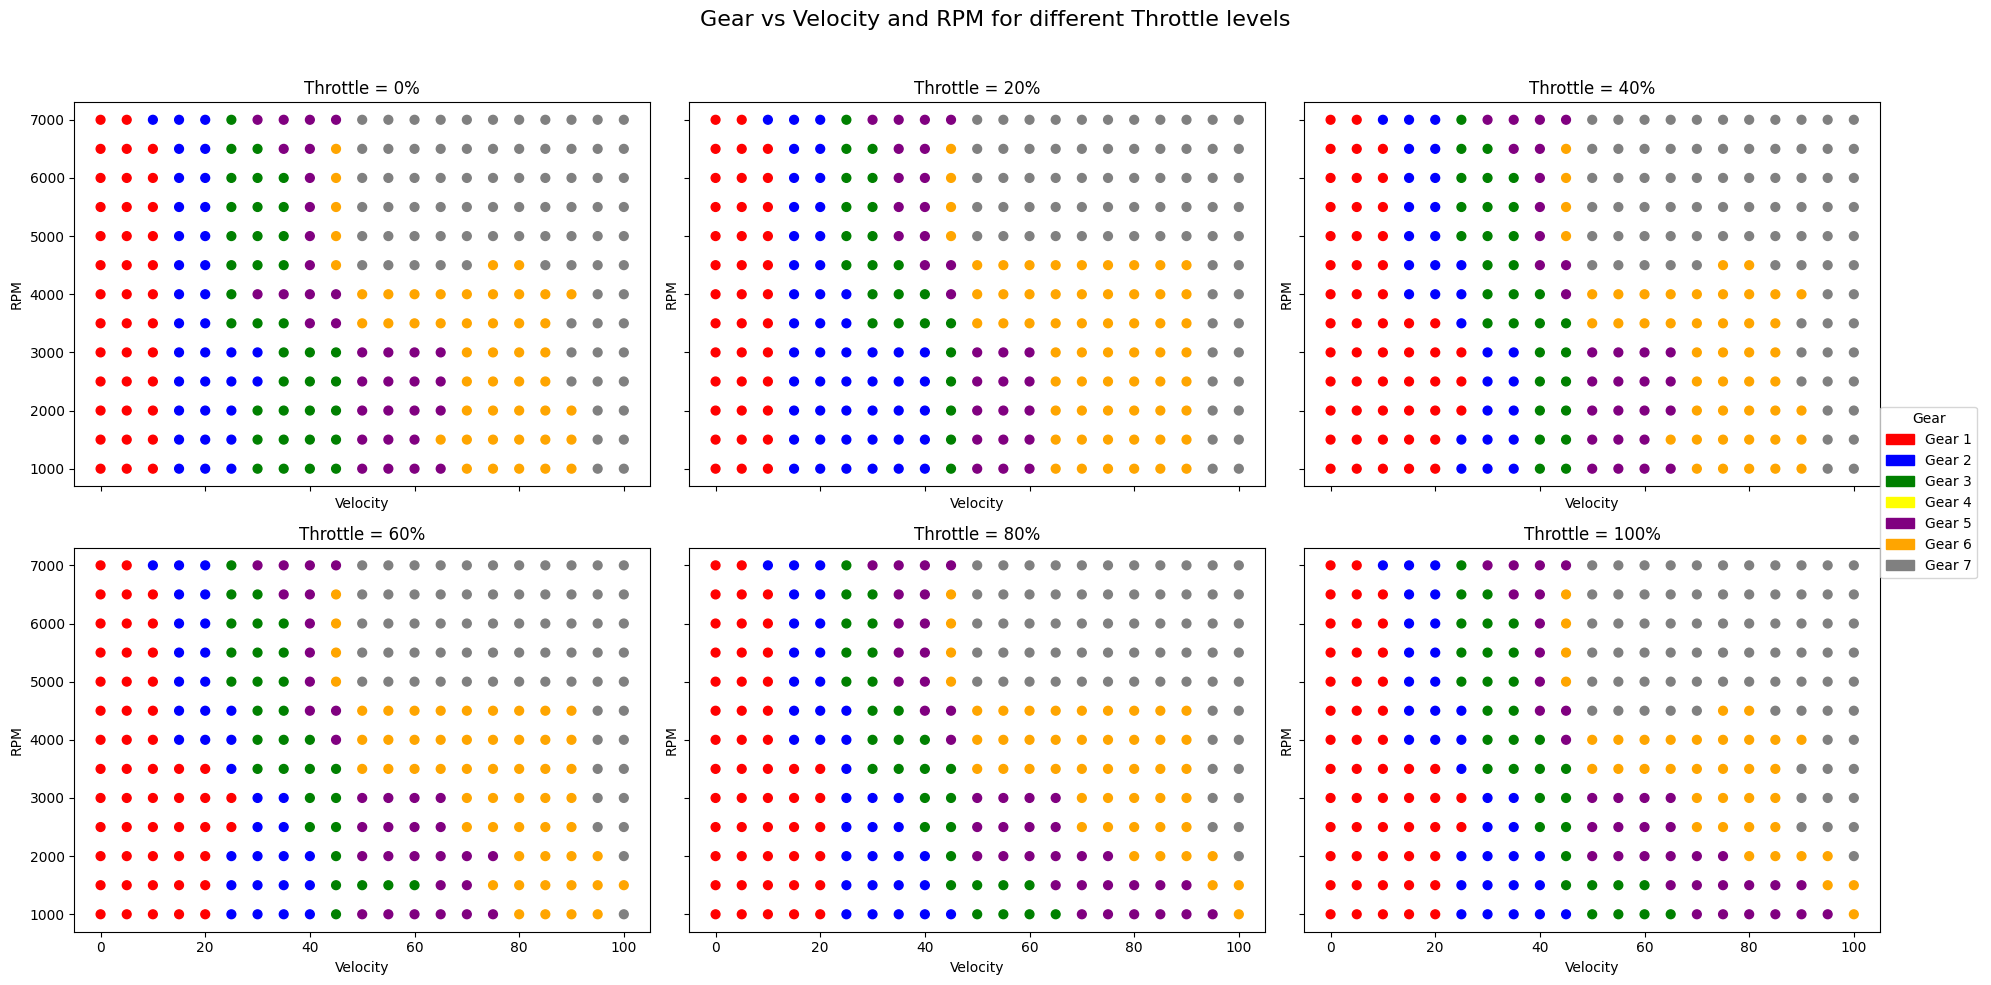

In [5]:
throttle_values = [0, 20, 40, 60, 80, 100]
gear_labels = [1, 2, 3, 4, 5, 6, 7]
my_palette = ["red", "blue", "green", "yellow", "purple", "orange", "grey"]
custom_cmap = mcolors.ListedColormap(my_palette, name='gear_palette')

fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)

velocities = range(0, 101, 5)
rpms = range(1000, 7001, 500)

for ax, thr in zip(axs.flat, throttle_values):
    data = []
    for v in velocities:
        for r in rpms:
            _, second = GearShift(v, r, thr)
            data.append((v, r, second))

    vel, rpm, gear = zip(*data)

    scatter = ax.scatter(vel, rpm, c=gear, cmap=custom_cmap, s=40)
    ax.set_title(f"Throttle = {thr}%")
    ax.set_xlabel('Velocity')
    ax.set_ylabel('RPM')

legend_handles = [
    Patch(color=color, label=f"Gear {label}") for color, label in zip(my_palette, gear_labels)
]
fig.legend(handles=legend_handles, title="Gear", loc="center right", borderaxespad=1.0)

plt.suptitle("Gear vs Velocity and RPM for different Throttle levels", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.96])
plt.show()


### Simulation of car acceleration

In [ ]:

# Constants
Th = 50
velo_gen = (v for v in range(0, 120, 5))
rpm_step = round(120 / (5 * 7))
rpm_gen = (r for r in range(0, 8000, rpm_step))

# Setup plot
fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 120)
ax.set_ylim(0.5, 7.5)
ax.set_xlabel("Velocity (km/h)")
ax.set_ylabel("Gear")
ax.set_title(f"Throttle Level = {Th}")

# State
x_data = []
y_data = []

# Wrap rpm_gen in a container so we can reassign inside update()
state = {
    'velo_gen': velo_gen,
    'rpm_gen': rpm_gen,
}

def update(frame):
    try:
        v = next(state['velo_gen'])
    except StopIteration:
        return line,  # Stop when velocity ends

    try:
        r = next(state['rpm_gen'])
    except StopIteration:
        state['rpm_gen'] = (r for r in range(0, 8000, rpm_step))  # reset
        r = next(state['rpm_gen'])

    g = GearShift(v, r, Th)

    x_data.append(v)
    y_data.append(g)

    line.set_data(x_data, y_data)
    return line,

ani = anim.FuncAnimation(fig, update, frames=range(0, 120, 5), interval=300, blit=True)
plt.show()

c:\workspace\Gear-change-FuzzyLogic\.venv\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (4,).

<Figure size 1200x600 with 1 Axes>